# Simple Linear Regression With OLS

## Assignment: predicting house prices

Now, it's your turn to design your first regression model. In this module, you'll be using a version of the "House Prices" dataset from Kaggle that we've ported to a Postgres database. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/2.solution_simple_linear_regression_models.ipynb).



In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sqlalchemy import create_engine
import warnings
import ds_useful

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [111]:
# Establish postgres access details
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Start the engine and connect to the database
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Perform a select query
df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

# Dispose the engine. We don't need it anymore
engine.dispose()

## Exploration

In [112]:
# Investigate the dataset

df.select_dtypes('object').head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [113]:
df.select_dtypes('number').head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

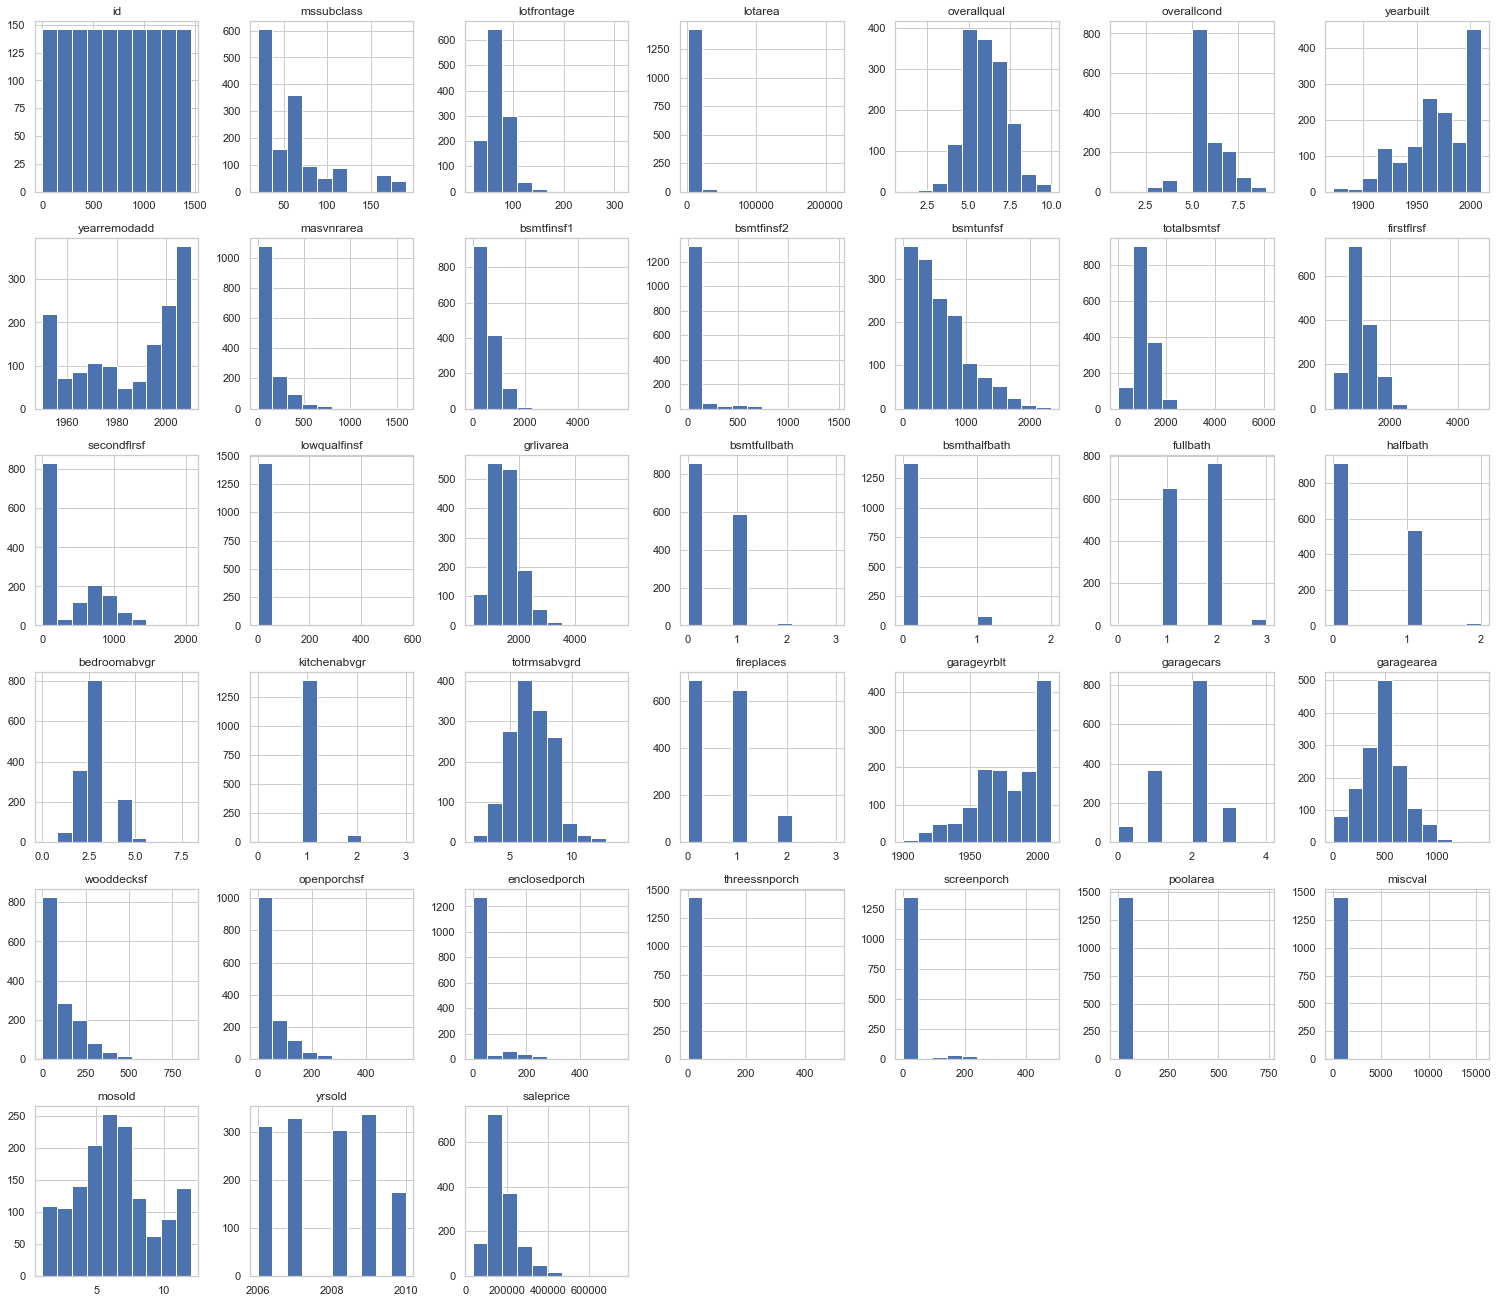

In [115]:
ds_useful.auto_subplots(df)

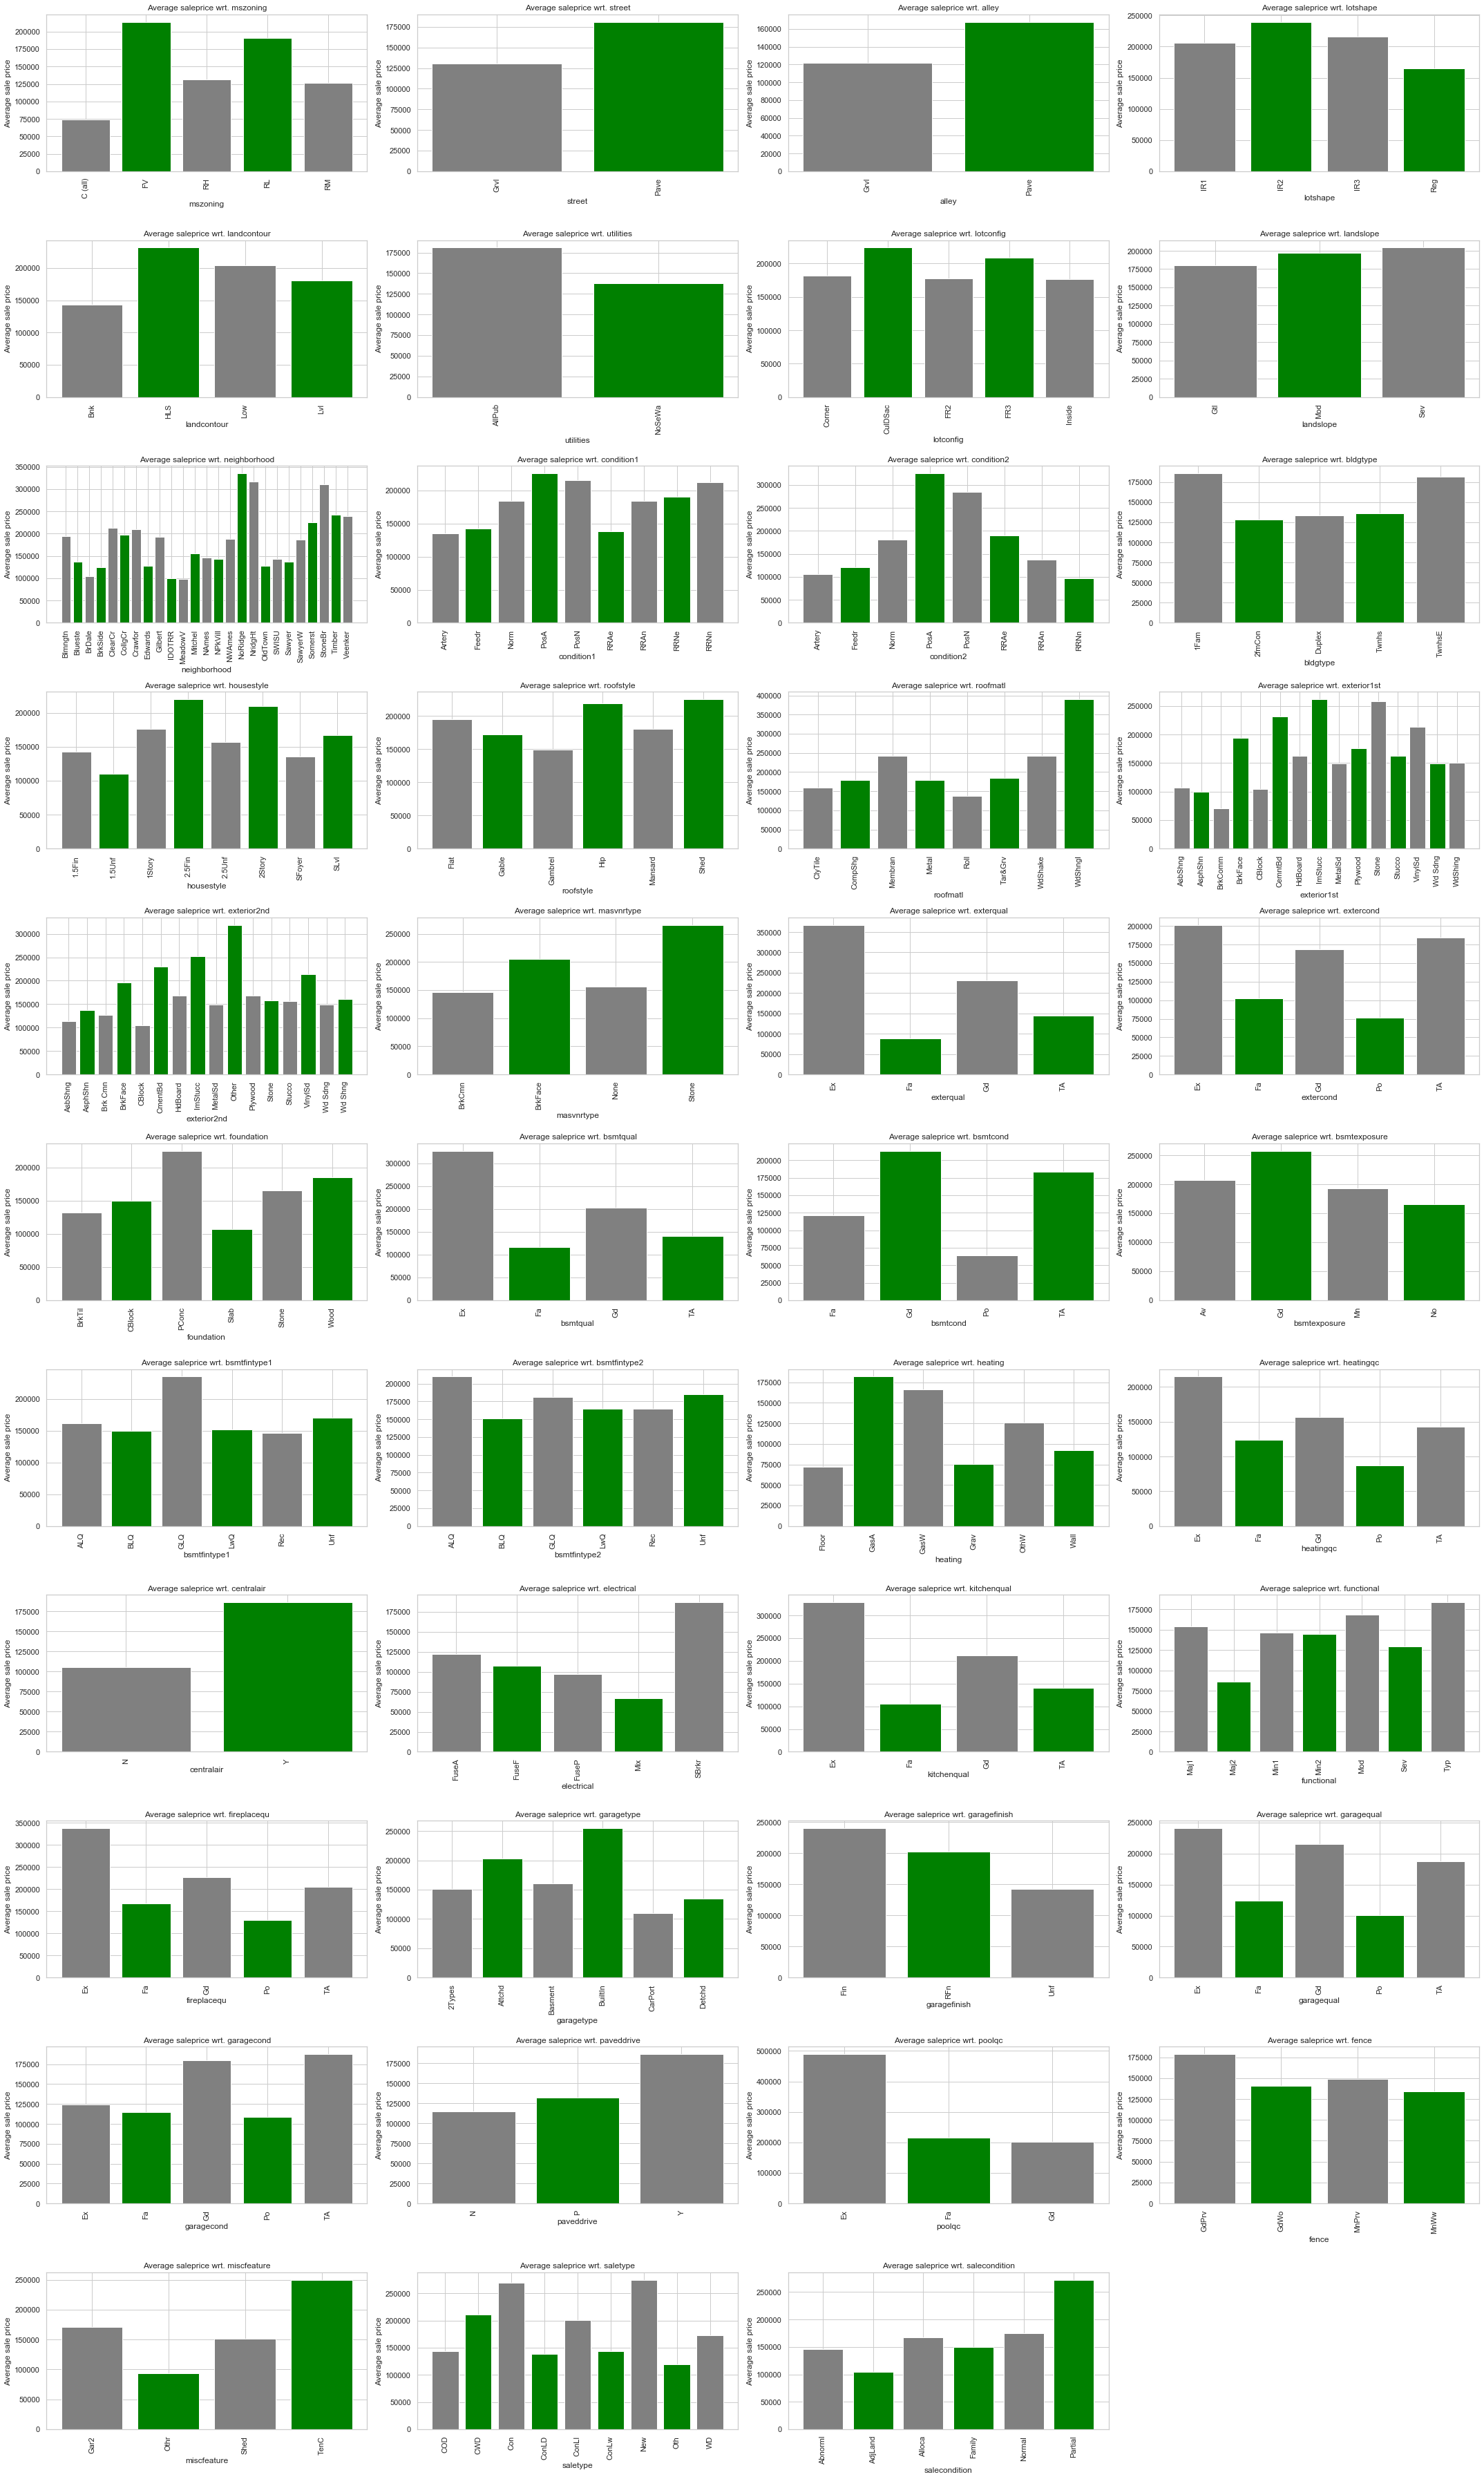

In [335]:
plt.figure(figsize=(30,50))

for index, column in enumerate(df.select_dtypes('object')):
    plt.subplot(11,4,index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [116]:
corr = df.corr()

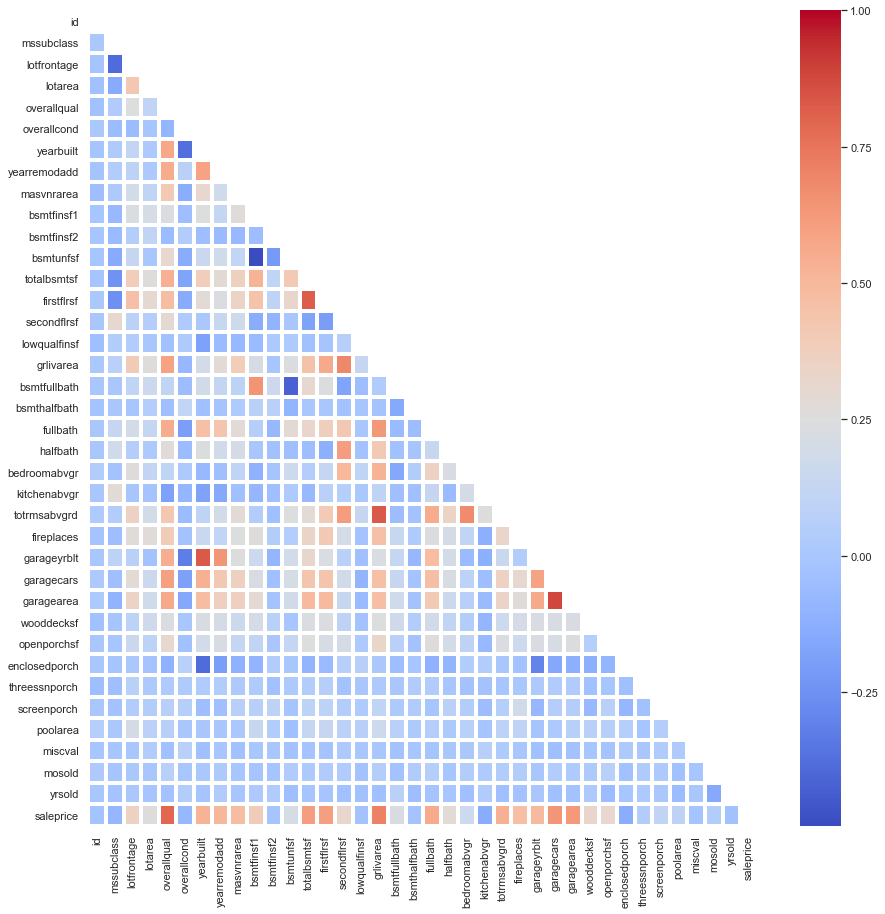

In [117]:
plt.figure(figsize=(15,15))
plt.subplot(111)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, annot=False, linewidths=3, cmap='coolwarm')
plt.show()

## Data Cleaning
### Missings

In [118]:
# Identify the percentage of missing data in each row
missings = ds_useful.missingness_summary(df, print_log = True)

poolqc           99.520548
miscfeature      96.301370
alley            93.767123
fence            80.753425
fireplacequ      47.260274
                   ...    
centralair        0.000000
salecondition     0.000000
heating           0.000000
totalbsmtsf       0.000000
id                0.000000
Length: 81, dtype: float64


In [301]:
# Create a smaller dataframe, dropping columns with more than 5% missing data
short_df = df.drop(missings.loc[missings > 5].index, axis=1)
ds_useful.missingness_summary(short_df)

bsmtfintype2    2.602740
bsmtexposure    2.602740
bsmtfintype1    2.534247
bsmtcond        2.534247
bsmtqual        2.534247
                  ...   
centralair      0.000000
heatingqc       0.000000
heating         0.000000
totalbsmtsf     0.000000
id              0.000000
Length: 70, dtype: float64

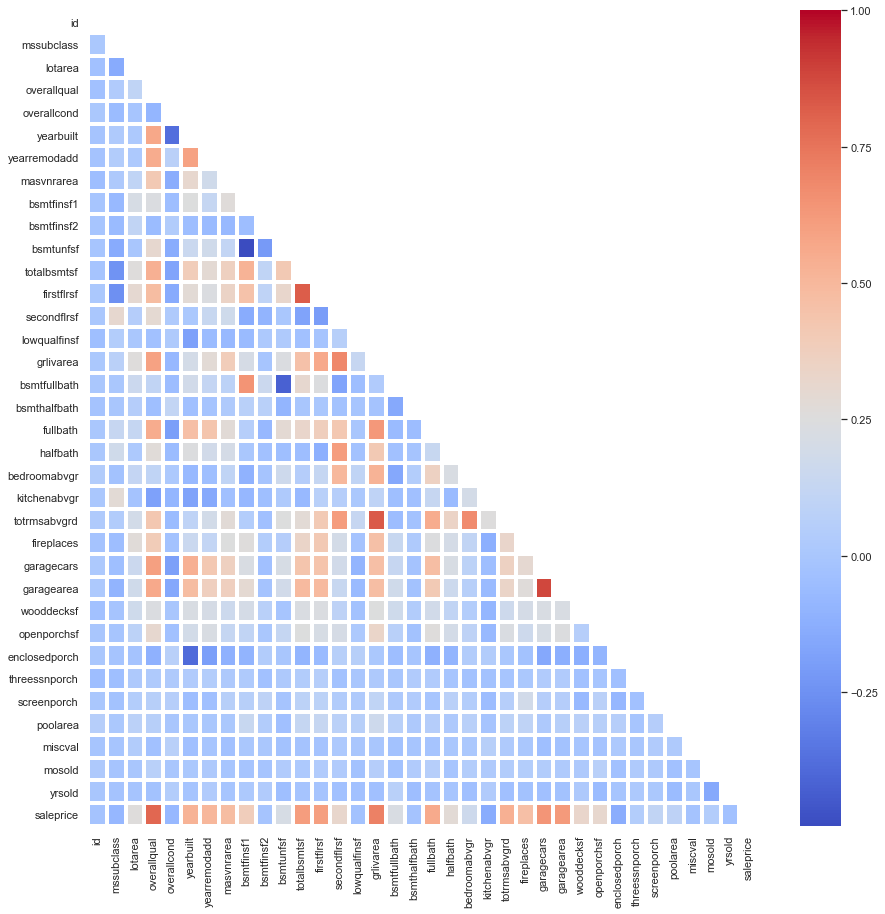

In [302]:
# Examine the correlation between numerical variables
plt.figure(figsize=(15,15))
plt.subplot(111)
corr = short_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, annot=False, linewidths=3, cmap='coolwarm')
plt.show()

### Similar Variables

In [303]:
# First we programmatically find similar pairs

def similar_variables(df, target, similarity_threshold=.9, print_log=False):
    corr = df.corr()

    feature_corr = corr.drop('saleprice', axis=1).drop('saleprice', axis=0)
    target_corr = corr.loc['saleprice']

    similar_pairs = []
    for col in feature_corr.columns:
        for index in feature_corr.index:
            if np.abs(feature_corr.loc[index, col]) > similarity_threshold and index != col and [col, index] not in similar_pairs:
                similar_pairs.append([index, col])

    # Then we'll find the variable in each similar pair that is less correlated (which we'll drop later)
    drop_variables = []
    corr_to_target = []

    for pair in similar_pairs:
        print(target_corr[pair[0]], target_corr[pair[1]])
        if target_corr[pair[0]] < target_corr[pair[1]]:
            drop_variables.append(pair[0])
            corr_to_target.append(target_corr[pair[0]])
        else:
            drop_variables.append(pair[1])
            corr_to_target.append(target_corr[pair[0]])

    S = pd.Series(corr_to_target, index=drop_variables)
    
    if print_log:
        print(S)
    
    return S

drop_variables = similar_variables(short_df, 'saleprice', similarity_threshold=.7)
drop_variables

0.6058521846919166 0.6135805515591944
0.5337231555820237 0.7086244776126511
0.6234314389183598 0.640409197258349


firstflrsf      0.605852
totrmsabvgrd    0.533723
garagearea      0.623431
dtype: float64

In [304]:
short_df.drop(drop_variables.index, axis=1, inplace=True)
short_df

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


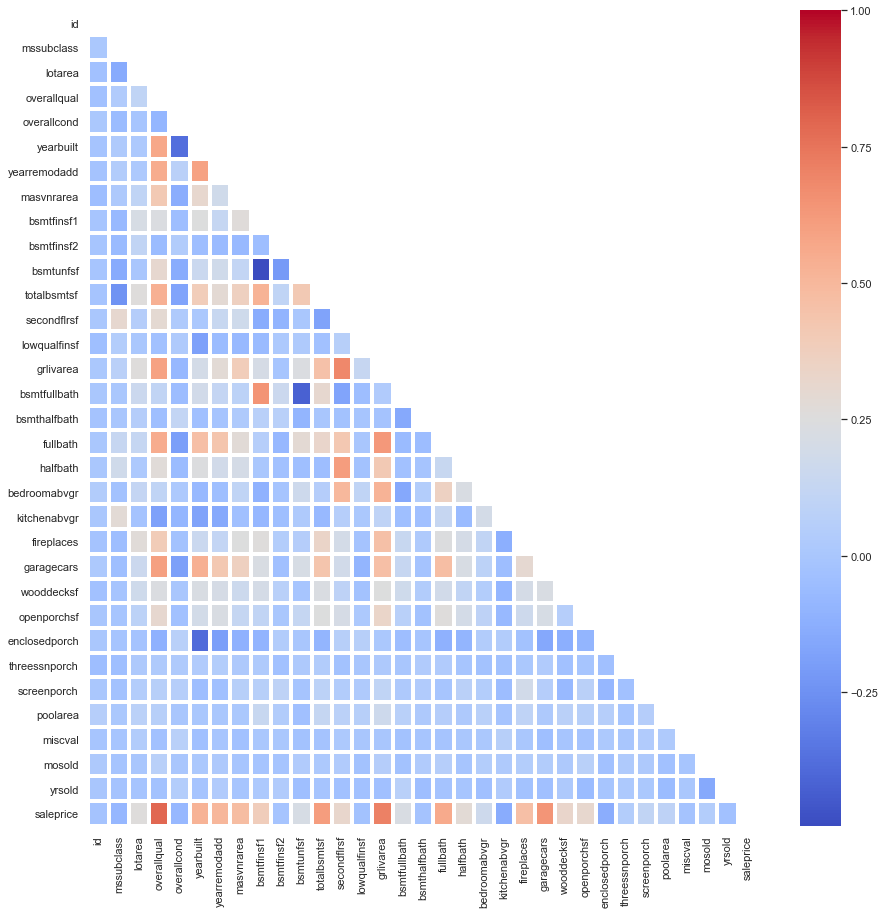

In [305]:
plt.figure(figsize=(15,15))
plt.subplot(111)
corr = short_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, annot=False, linewidths=3, cmap='coolwarm')
plt.show()

### Zeros

In [307]:
# Define a function that returns a Series including a summary of how many zeroes

def repeats_summary(df, sort='desc', print_log=False, value_agg='none', value=0):
    repeats_percents = []
    print_value = []
    for col in df.columns:
        if value_agg == 'none':
            value = value
            print_value = []
        elif value_agg == 'mode':
            value = df[col].mode().iloc[0]
        elif value_agg == 'mean':
            value = df[col].mean().iloc[0]
        elif value_agg == 'median':
            value = df[col].median().iloc[0]
        elif value_agg == 'max':
            value = df[col].max().iloc[0]
        elif value_agg == 'min':
            value = df[col].min().iloc[0]
        else: raise ValueError('Wrong entry for \'value_agg\'. Will accept \'mode\', \'mean\', \'median\', \'max\', \'min\'')

        repeats_percents.append(len(df.loc[df[col] == value])*100/len(df))
        print_value.append(value)

    S = pd.Series(repeats_percents, index=df.columns)
    if sort == 'desc':
        S = S.sort_values(ascending=False)
    elif sort == 'asc':
        S = S.sort_values(ascending=True)
    else: raise ValueError('Wrong entry for \'sort\'. Will accept \'asc\' or \'desc\'')

    if print_log:
        print(f'Repeated values: {print_value}\n{S}')

    return S

In [308]:
# Find the percentages of repeating 0s in numerical variables
repeats = repeats_summary(short_df.drop('saleprice', axis=1), print_log=True)

Repeated values: [0]
poolarea         99.520548
threessnporch    98.356164
lowqualfinsf     98.219178
miscval          96.438356
bsmthalfbath     94.383562
                   ...    
bsmtqual          0.000000
foundation        0.000000
extercond         0.000000
exterqual         0.000000
id                0.000000
Length: 66, dtype: float64


In [309]:
# Remove all columns where more than 25% of the values are 0
short_df.drop(repeats.loc[repeats > 25].index, axis=1, inplace=True)
short_df

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,kitchenabvgr,kitchenqual,functional,garagecars,paveddrive,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,Gd,Typ,2,Y,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,1,TA,Typ,2,Y,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,1,Gd,Typ,2,Y,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,1,Gd,Typ,3,Y,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,1,Gd,Typ,3,Y,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,TA,Typ,2,Y,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,TA,Min1,2,Y,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,Gd,Typ,1,Y,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,Gd,Typ,1,Y,4,2010,WD,Normal,142125


In [310]:
# Identify columns where there are a lot of the same category value
cat_repeats = repeats_summary(short_df.select_dtypes('object'), value_agg='mode', print_log=True)

Repeated values: ['RL', 'Pave', 'Reg', 'Lvl', 'AllPub', 'Inside', 'Gtl', 'NAmes', 'Norm', 'Norm', '1Fam', '1Story', 'Gable', 'CompShg', 'VinylSd', 'VinylSd', 'None', 'TA', 'TA', 'PConc', 'TA', 'TA', 'No', 'Unf', 'Unf', 'GasA', 'Ex', 'Y', 'SBrkr', 'TA', 'Typ', 'Y', 'WD', 'Normal']
utilities        99.931507
street           99.589041
condition2       98.972603
roofmatl         98.219178
heating          97.808219
landslope        94.657534
centralair       93.493151
functional       93.150685
paveddrive       91.780822
electrical       91.369863
landcontour      89.794521
bsmtcond         89.794521
extercond        87.808219
saletype         86.780822
condition1       86.301370
bsmtfintype2     86.027397
bldgtype         83.561644
salecondition    82.054795
mszoning         78.835616
roofstyle        78.150685
lotconfig        72.054795
bsmtexposure     65.273973
lotshape         63.356164
exterqual        62.054795
masvnrtype       59.178082
heatingqc        50.753425
kitchenqual      

In [311]:
short_df.drop(cat_repeats.loc[cat_repeats > 25].index, axis=1, inplace=True)
short_df

,id,mssubclass,lotarea,neighborhood,overallqual,overallcond,yearbuilt,yearremodadd,bsmtunfsf,totalbsmtsf,grlivarea,fullbath,bedroomabvgr,kitchenabvgr,garagecars,mosold,yrsold,saleprice
0,1,60,8450,CollgCr,7,5,2003,2003,150,856,1710,2,3,1,2,2,2008,208500
1,2,20,9600,Veenker,6,8,1976,1976,284,1262,1262,2,3,1,2,5,2007,181500
2,3,60,11250,CollgCr,7,5,2001,2002,434,920,1786,2,3,1,2,9,2008,223500
3,4,70,9550,Crawfor,7,5,1915,1970,540,756,1717,1,3,1,3,2,2006,140000
4,5,60,14260,NoRidge,8,5,2000,2000,490,1145,2198,2,4,1,3,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,Gilbert,6,5,1999,2000,953,953,1647,2,3,1,2,8,2007,175000
1456,1457,20,13175,NWAmes,6,6,1978,1988,589,1542,2073,2,3,1,2,2,2010,210000
1457,1458,70,9042,Crawfor,7,9,1941,2006,877,1152,2340,2,4,1,1,5,2010,266500
1458,1459,20,9717,NAmes,5,6,1950,1996,0,1078,1078,1,2,1,1,4,2010,142125


In [312]:
new_missings = ds_useful.missingness_summary(short_df, print_log=True)

saleprice       0.0
yrsold          0.0
mssubclass      0.0
lotarea         0.0
neighborhood    0.0
overallqual     0.0
overallcond     0.0
yearbuilt       0.0
yearremodadd    0.0
bsmtunfsf       0.0
totalbsmtsf     0.0
grlivarea       0.0
fullbath        0.0
bedroomabvgr    0.0
kitchenabvgr    0.0
garagecars      0.0
mosold          0.0
id              0.0
dtype: float64


In [320]:
# Drop rows with missing values in the categorical columns:
def drop_null_rows(df):
    for col in df.columns:
        df.drop(df.loc[df[col].isnull()].index, axis=0, inplace=True)
    return df

short_df = drop_null_rows(short_df)
short_df

,id,mssubclass,lotarea,neighborhood,overallqual,overallcond,yearbuilt,yearremodadd,bsmtunfsf,totalbsmtsf,grlivarea,fullbath,bedroomabvgr,kitchenabvgr,garagecars,mosold,yrsold,saleprice
0,1,60,8450,CollgCr,7,5,2003,2003,150,856,1710,2,3,1,2,2,2008,208500
1,2,20,9600,Veenker,6,8,1976,1976,284,1262,1262,2,3,1,2,5,2007,181500
2,3,60,11250,CollgCr,7,5,2001,2002,434,920,1786,2,3,1,2,9,2008,223500
3,4,70,9550,Crawfor,7,5,1915,1970,540,756,1717,1,3,1,3,2,2006,140000
4,5,60,14260,NoRidge,8,5,2000,2000,490,1145,2198,2,4,1,3,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,Gilbert,6,5,1999,2000,953,953,1647,2,3,1,2,8,2007,175000
1456,1457,20,13175,NWAmes,6,6,1978,1988,589,1542,2073,2,3,1,2,2,2010,210000
1457,1458,70,9042,Crawfor,7,9,1941,2006,877,1152,2340,2,4,1,1,5,2010,266500
1458,1459,20,9717,NAmes,5,6,1950,1996,0,1078,1078,1,2,1,1,4,2010,142125


### Outliers

In [321]:
# Identify outliers
ds_useful.outliers_summary(short_df, 1.5)

overallcond     8.561644
mssubclass      7.054795
lotarea         4.726027
kitchenabvgr    4.657534
saleprice       4.178082
totalbsmtsf     4.178082
bedroomabvgr    2.397260
grlivarea       2.123288
bsmtunfsf       1.986301
yearbuilt       0.479452
garagecars      0.342466
overallqual     0.136986
fullbath        0.000000
yrsold          0.000000
yearremodadd    0.000000
mosold          0.000000
id              0.000000
dtype: float64

In [322]:
new_df = short_df.copy()

def get_percentiles(df, column_name, threshold):
    min_val, max_val = ds_useful.get_minmax_with_threshold(df[column_name], threshold)

    max_percentile = df.loc[df[column_name] >= max_val, column_name].count() /  len(df)
    min_percentile = df.loc[df[column_name] <= min_val, column_name].count() / len(df)
    
    return tuple([min_percentile, max_percentile])

for col in short_df.select_dtypes('number').columns:
    percentiles = get_percentiles(short_df, col, 1.5)
    new_df[col] = stats.mstats.winsorize(short_df[col], percentiles)

new_df

,id,mssubclass,lotarea,neighborhood,overallqual,overallcond,yearbuilt,yearremodadd,bsmtunfsf,totalbsmtsf,grlivarea,fullbath,bedroomabvgr,kitchenabvgr,garagecars,mosold,yrsold,saleprice
0,1,60,8450,CollgCr,7,5,2003,2003,150,856,1710,2,3,2,2,2,2008,208500
1,2,20,9600,Veenker,6,7,1976,1976,284,1262,1262,2,3,2,2,5,2007,181500
2,3,60,11250,CollgCr,7,5,2001,2002,434,920,1786,2,3,2,2,9,2008,223500
3,4,70,9550,Crawfor,7,5,1915,1970,540,756,1717,1,3,2,3,2,2006,140000
4,5,60,14260,NoRidge,8,5,2000,2000,490,1145,2198,2,4,2,3,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,Gilbert,6,5,1999,2000,953,953,1647,2,3,2,2,8,2007,175000
1456,1457,20,13175,NWAmes,6,6,1978,1988,589,1542,2073,2,3,2,2,2,2010,210000
1457,1458,70,9042,Crawfor,7,7,1941,2006,877,1152,2340,2,4,2,1,5,2010,266500
1458,1459,20,9717,NAmes,5,6,1950,1996,0,1078,1078,1,2,2,1,4,2010,142125


In [323]:
ds_useful.outliers_summary(new_df, 1.5)

totalbsmtsf     1.643836
bedroomabvgr    0.410959
bsmtunfsf       0.000000
mssubclass      0.000000
lotarea         0.000000
overallqual     0.000000
overallcond     0.000000
yearbuilt       0.000000
yearremodadd    0.000000
saleprice       0.000000
yrsold          0.000000
grlivarea       0.000000
fullbath        0.000000
kitchenabvgr    0.000000
garagecars      0.000000
mosold          0.000000
id              0.000000
dtype: float64

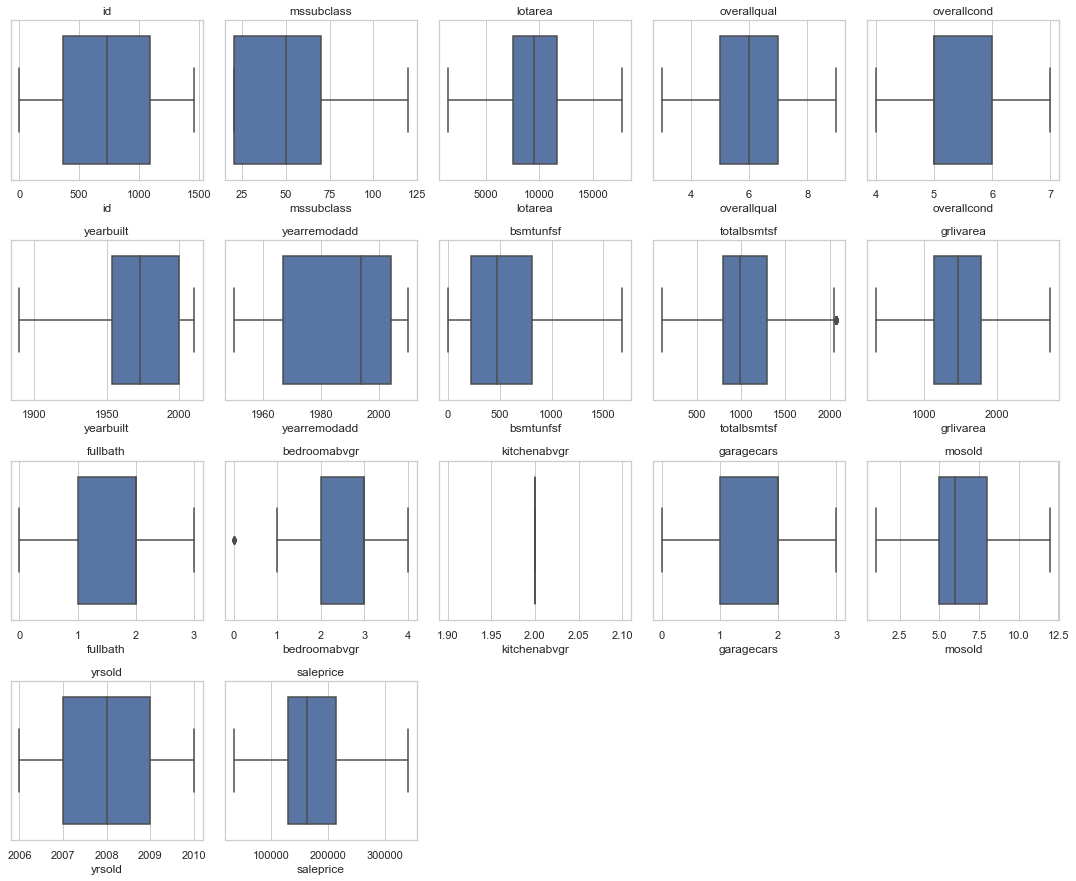

In [324]:
ds_useful.auto_subplots(new_df, kind='boxplot')

In [331]:
# One-hot-encode stuff
Y = new_df['saleprice']
X = pd.get_dummies(new_df.drop('saleprice', axis=1).select_dtypes('object'), drop_first=True)
for col in new_df.drop('saleprice', axis=1).select_dtypes('number').columns:
    X[col] = new_df[col]

print('target:\n', Y.head(), '\n\nfeatures:')
X.head()

target:
 0    208500
1    181500
2    223500
3    140000
4    250000
Name: saleprice, dtype: int64 

features:


,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,...,yearremodadd,bsmtunfsf,totalbsmtsf,grlivarea,fullbath,bedroomabvgr,kitchenabvgr,garagecars,mosold,yrsold
0,0,0,0,0,1,0,0,0,0,0,...,2003,150,856,1710,2,3,2,2,2,2008
1,0,0,0,0,0,0,0,0,0,0,...,1976,284,1262,1262,2,3,2,2,5,2007
2,0,0,0,0,1,0,0,0,0,0,...,2002,434,920,1786,2,3,2,2,9,2008
3,0,0,0,0,0,1,0,0,0,0,...,1970,540,756,1717,1,3,2,3,2,2006
4,0,0,0,0,0,0,0,0,0,0,...,2000,490,1145,2198,2,4,2,3,12,2008


## Regression Model

In [332]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     325.5
Date:                Sun, 16 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:01:12   Log-Likelihood:                -16623.
No. Observations:                1460   AIC:                         3.333e+04
Df Residuals:                    1420   BIC:                         3.354e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
neighborhood_Blueste -2.237e+04   1.63e+04     -1.372      0.170   -5.44e+04    9615.436
neighborhood_BrDale  -1.831e+04   7881.276     -2.324      0.020   -3.38e+04   -2854.741
neighborhood_BrkSide -4867.3235   6950.460     -0.700      0.484   -1.85e+04    8766.949
neighborhood_ClearCr  -864.0665   7352.944     -0.118      0.906   -1.53e+04    1.36e+04
neighborhood_CollgCr -1.043e+04   5967.318     -1.748      0.081   -2.21e+04    1276.985
neighborhood_Crawfor  1.066e+04   6919.942      1.541      0.124   -2910.599    2.42e+04
neighborhood_Edwards -1.912e+04   6471.548     -2.955      0.003   -3.18e+04   -6425.886
neighborhood_Gilbert -1.288e+04   6294.442     -2.046      0.041   -2.52e+04    -530.705
neighborhood_IDOTRR  -1.576e+04   7348.845     -2.144      0.032   -3.02e+04   -1341.839
neighborhood_MeadowV  -1.13e+04   7866.272     -1.437      0.151   -2.67e+04    4127.727
neighborhood_Mitchel -2.236e+04   6623.802     -3.375      0.001   -3.54e+04   -9363.709
neighborhood_NAmes   -1.934e+04   6277.454     -3.080      0.002   -3.17e+04   -7022.708
neighborhood_NPkVill -1.137e+04   9148.980     -1.242      0.214   -2.93e+04    6580.740
neighborhood_NWAmes  -2.484e+04   6470.213     -3.839      0.000   -3.75e+04   -1.21e+04
neighborhood_NoRidge   1.52e+04   6782.362      2.241      0.025    1892.665    2.85e+04
neighborhood_NridgHt  2.253e+04   6108.854      3.688      0.000    1.05e+04    3.45e+04
neighborhood_OldTown -1.948e+04   6730.965     -2.893      0.004   -3.27e+04   -6271.552
neighborhood_SWISU   -1.195e+04   7796.563     -1.533      0.126   -2.72e+04    3342.062
neighborhood_Sawyer   -2.14e+04   6621.377     -3.233      0.001   -3.44e+04   -8416.185
neighborhood_SawyerW -1.539e+04   6422.142     -2.396      0.017    -2.8e+04   -2792.460
neighborhood_Somerst  6697.7266   5981.546      1.120      0.263   -5035.890    1.84e+04
neighborhood_StoneBr  2.078e+04   7033.612      2.955      0.003    6987.513    3.46e+04
neighborhood_Timber  -1451.7734   6826.144     -0.213      0.832   -1.48e+04    1.19e+04
neighborhood_Veenker  5170.5793   8801.628      0.587      0.557   -1.21e+04    2.24e+04
id                      -1.0521      1.358     -0.775      0.439      -3.716       1.612
mssubclass            -138.8550     22.486     -6.175      0.000    -182.965     -94.745
lotarea                  1.8370      0.233      7.893      0.000       1.380       2.294
overallqual           1.238e+04    773.436     16.007      0.000    1.09e+04    1.39e+04
overallcond           7772.3970    813.712      9.552      0.000    6176.191    9368.603
yearbuilt              376.5685     48.278      7.800      0.000     281.866     471.271
yearremodadd           176.8435     41.572      4.254      0.000      95.295     258.392
bsmtunfsf              -18.5786      1.614    -11.511    